In [4]:
pip install pandas pyarrow

In [5]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
historique_path = "/content/drive/My Drive/AirLiquideJL/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet"
historique_data = pd.read_parquet(historique_path)
print(historique_data.head())


                           price
date                            
2016-12-31 23:00:00+00:00  58.82
2017-01-01 00:00:00+00:00  58.23
2017-01-01 01:00:00+00:00  51.95
2017-01-01 02:00:00+00:00  47.27
2017-01-01 03:00:00+00:00  45.49


In [8]:
import os

scenarios_path = "/content/drive/My Drive/AirLiquideJL/scenarios synthetiques/prix"
all_scenarios = []
for file in os.listdir(scenarios_path):
    if file.endswith(".parquet"):
        file_path = os.path.join(scenarios_path, file)
        scenario = pd.read_parquet(file_path)
        all_scenarios.append(scenario)

# Combiner tous les scénarios en un seul DataFrame
scenarios_data = pd.concat(all_scenarios, axis=0)
print(scenarios_data.head())


   price  dayofweek  hourofday
0  31.66          0          0
1  31.06          0          1
2  27.81          0          2
3  27.54          0          3
4  25.04          0          4


In [9]:
print(historique_data.info())
print(historique_data.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2016-12-31 23:00:00+00:00 to 2020-12-31 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB
None
              price
count  35064.000000
mean      41.697606
std       18.600285
min      -75.820000
25%       30.180000
50%       39.900000
75%       51.422500
max      259.950000


In [11]:
print(historique_data.isnull().sum())
print(scenarios_data.isnull().sum())


price    0
dtype: int64
price        0
dayofweek    0
hourofday    0
dtype: int64


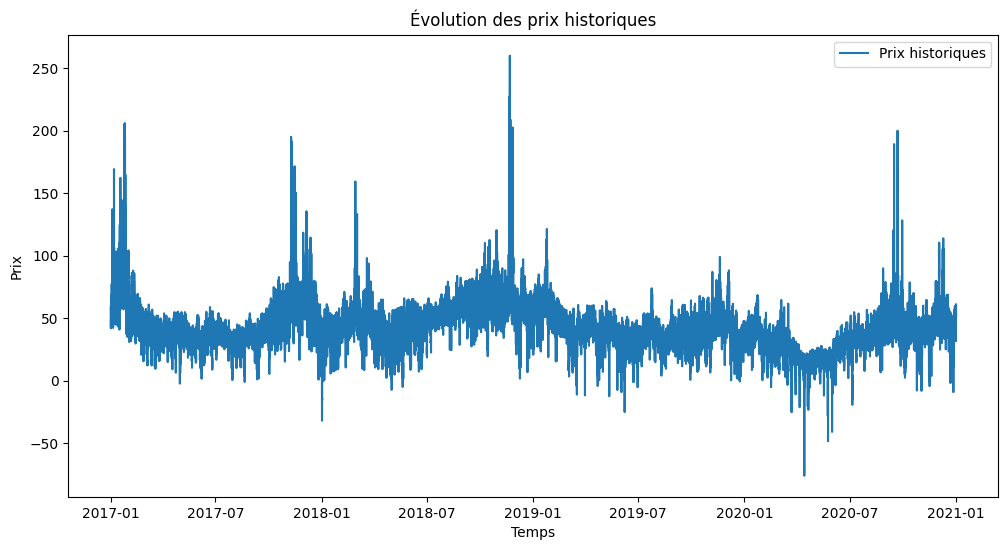

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(historique_data.index, historique_data['price'], label='Prix historiques')
plt.title('Évolution des prix historiques')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.show()


In [ ]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
pip install tqdm


In [13]:
import warnings
warnings.filterwarnings("ignore")  # Ignore tous les avertissements


In [14]:
print(historique_data['price'].isnull().sum())


0


In [15]:
historique_data['price'].fillna(historique_data['price'].mean(), inplace=True)


In [16]:
historique_data['price'] = pd.to_numeric(historique_data['price'], errors='coerce')


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Charger les données historiques
historique_path = "/content/drive/My Drive/AirLiquideJL/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet"
historique_data = pd.read_parquet(historique_path)

# Vérifier que la colonne 'price' existe
if 'price' not in historique_data.columns:
    raise ValueError("La colonne 'price' est manquante dans les données.")

# Normalisation des données (entre 0 et 1)
scaler = MinMaxScaler()
historique_data['price_scaled'] = scaler.fit_transform(historique_data[['price']])

# Segmenter les données en séquences temporelles
def create_sequences(data, seq_length=24):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 24  # Longueur des séquences (par exemple, 24 heures)
price_sequences = create_sequences(historique_data['price_scaled'].values, seq_length)

# Restructurer les données pour inclure feature_dim
price_sequences = price_sequences.reshape(price_sequences.shape[0], price_sequences.shape[1], 1)
print(f"Dimensions des données préparées : {price_sequences.shape}")


Dimensions des données préparées : (35040, 24, 1)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers

# Générateur
def build_generator(seq_length, feature_dim, latent_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(seq_length * feature_dim),
        layers.Reshape((seq_length, feature_dim)),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(feature_dim, kernel_size=3, padding='same', activation='sigmoid')  # Sortie normalisée entre 0 et 1
    ])
    return model

# Discriminateur
def build_discriminator(seq_length, feature_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(seq_length, feature_dim)),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialisation
latent_dim = 100  # Dimension du bruit aléatoire
feature_dim = price_sequences.shape[2]

generator = build_generator(seq_length, feature_dim, latent_dim)
discriminator = build_discriminator(seq_length, feature_dim)

# Compilation des modèles
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')


In [20]:
def train_gan(generator, discriminator, gan, data, latent_dim, epochs=1000, batch_size=32):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Entraîner le discriminateur
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entraîner le générateur
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))  # Le générateur essaie de tromper le discriminateur
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Gérer les cas où les pertes sont des tableaux numpy
        d_loss_value = float(d_loss[0]) if isinstance(d_loss, (list, np.ndarray)) else float(d_loss)
        g_loss_value = float(g_loss[0]) if isinstance(g_loss, (list, np.ndarray)) else float(g_loss)

        # Affichage des pertes
        if epoch % 100 == 0:
            print(f"Epoch {epoch} / {epochs} - D Loss: {d_loss_value:.4f}, G Loss: {g_loss_value:.4f}")



train_gan(generator, discriminator, gan, price_sequences, latent_dim, epochs=500, batch_size=32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
# Générer des scénarios synthétiques
num_scenarios = 10  # Nombre de scénarios à générer
noise = np.random.normal(0, 1, (num_scenarios, latent_dim))  # Générer du bruit
synthetic_data = generator.predict(noise)  # Utiliser le générateur pour créer des données synthétiques

# Vérification des dimensions des données générées
print(f"Dimensions des données synthétiques : {synthetic_data.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Dimensions des données synthétiques : (10, 24, 1)


In [ ]:
# Dénormaliser les données
synthetic_data_denormalized = [scaler.inverse_transform(seq[:, 0].reshape(-1, 1)) for seq in synthetic_data]

# Vérifier les dimensions des données dénormalisées
print(f"Dimensions après dénormalisation : {np.array(synthetic_data_denormalized).shape}")


Dimensions après dénormalisation : (10, 24, 1)


In [ ]:
# Conversion en DataFrame
synthetic_df = pd.DataFrame({
    f'Scenario_{i+1}': seq.flatten() for i, seq in enumerate(synthetic_data_denormalized)
})

# Sauvegarder les scénarios dans un fichier Parquet
output_path = '/content/drive/My Drive/AirLiquideJL/synthetic_convgan.parquet'
synthetic_df.to_parquet(output_path)
print(f"Scénarios sauvegardés avec succès dans {output_path}")


Scénarios sauvegardés avec succès dans /content/drive/My Drive/AirLiquideJL/synthetic_convgan.parquet


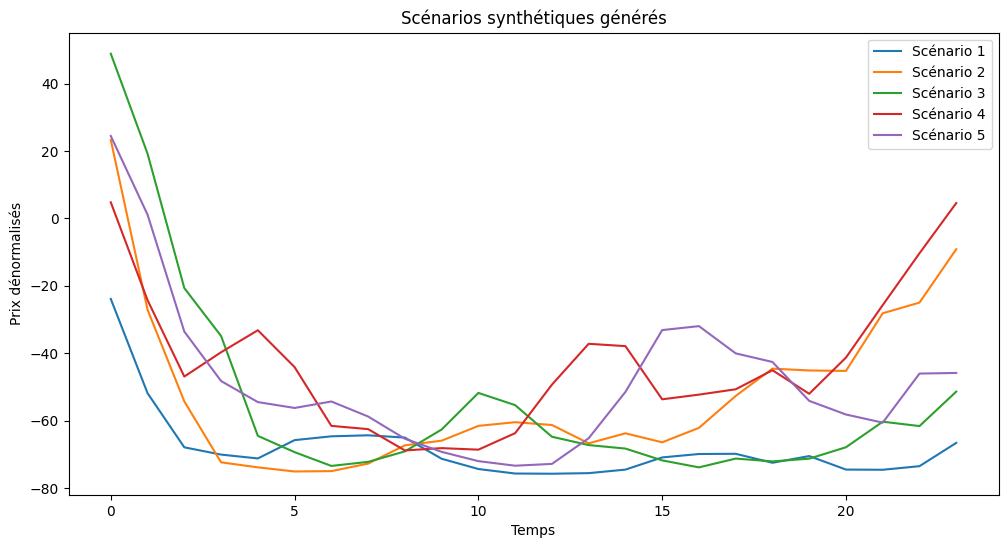

In [ ]:
import matplotlib.pyplot as plt

# Visualiser les scénarios générés
plt.figure(figsize=(12, 6))
for i, seq in enumerate(synthetic_data_denormalized[:5]):  # Visualiser les 5 premiers scénarios
    plt.plot(seq, label=f'Scénario {i+1}')
plt.title("Scénarios synthétiques générés")
plt.xlabel("Temps")
plt.ylabel("Prix dénormalisés")
plt.legend()
plt.show()


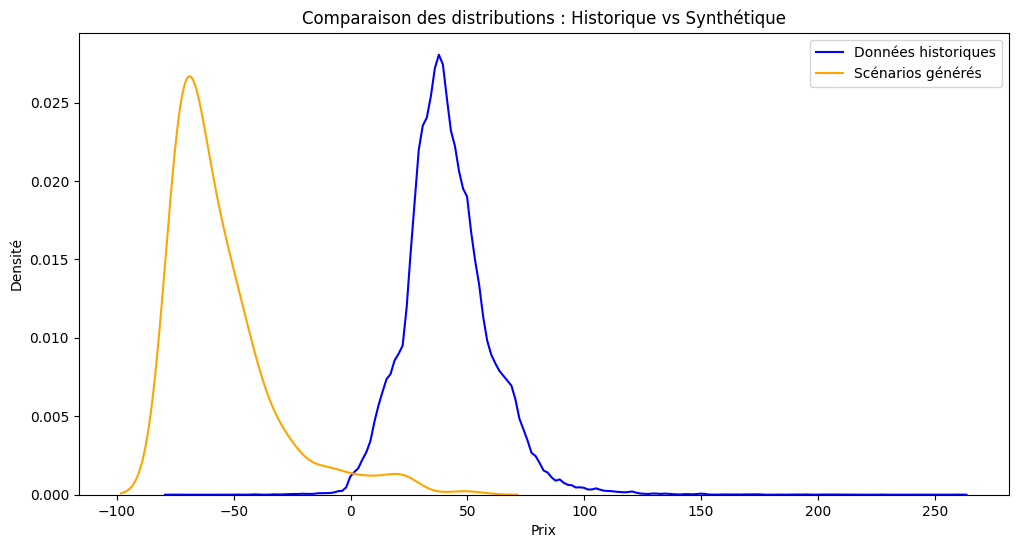

In [ ]:
import seaborn as sns

# Extraire les données historiques dénormalisées
historical_prices = scaler.inverse_transform(price_sequences[:, :, 0].flatten().reshape(-1, 1)).flatten()

# Combiner les scénarios générés
generated_prices = np.array(synthetic_data_denormalized).flatten()

# Tracer les distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(historical_prices, label='Données historiques', color='blue')
sns.kdeplot(generated_prices, label='Scénarios générés', color='orange')
plt.title('Comparaison des distributions : Historique vs Synthétique')
plt.xlabel('Prix')
plt.ylabel('Densité')
plt.legend()
plt.show()


In [ ]:
# Statistiques descriptives des données historiques
historical_stats = pd.Series(historical_prices).describe()

# Statistiques descriptives des données générées
generated_stats = pd.Series(generated_prices).describe()

print("Statistiques descriptives des données historiques :\n", historical_stats)
print("\nStatistiques descriptives des données générées :\n", generated_stats)


Statistiques descriptives des données historiques :
 count    840960.000000
mean         41.690990
std          18.603863
min         -75.820000
25%          30.170000
50%          39.900000
75%          51.400000
max         259.950000
dtype: float64

Statistiques descriptives des données générées :
 count    240.000000
mean     -55.655334
std       22.432295
min      -75.780296
25%      -71.854397
50%      -62.777710
75%      -48.293524
max       48.870468
dtype: float64


In [ ]:
# Préparer les données augmentées
historical_data_expanded = price_sequences[:, :, 0].reshape(-1, seq_length)
generated_data_expanded = np.array(synthetic_data_denormalized).reshape(-1, seq_length)

# Combiner les deux
combined_data = np.vstack([historical_data_expanded, generated_data_expanded])
combined_labels = np.array([1] * historical_data_expanded.shape[0] + [0] * generated_data_expanded.shape[0])

print(f"Dimensions des données combinées : {combined_data.shape}")
print(f"Labels associés : {combined_labels.shape}")


Dimensions des données combinées : (35050, 24)
Labels associés : (35050,)


In [ ]:
pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Préparer les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Entraîner un modèle XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Évaluer les performances
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) sur les données de test : {mse:.4f}")


Mean Squared Error (MSE) sur les données de test : 0.0000


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chemin des données historiques et des scénarios
historical_data_path = "/content/drive/My Drive/AirLiquideJL/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet"
scenarios_path = "/content/drive/My Drive/AirLiquideJL/scenarios synthetiques/prix"

# Charger les données historiques
historical_data = pd.read_parquet(historical_data_path)

# Charger les scénarios générés
all_scenarios = []
for file in os.listdir(scenarios_path):
    if file.endswith(".parquet"):
        file_path = os.path.join(scenarios_path, file)
        scenario = pd.read_parquet(file_path)
        all_scenarios.append(scenario)

# Combiner les scénarios
scenarios_data = pd.concat(all_scenarios, axis=0).reset_index(drop=True)

# Combiner les données historiques et synthétiques
combined_data = pd.concat([historical_data['price'], scenarios_data], axis=0).reset_index(drop=True)

# Normaliser les données
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(combined_data.values.reshape(-1, 1)).flatten()

print(f"Taille totale des données après combinaison et normalisation : {len(normalized_data)}")


Taille totale des données après combinaison et normalisation : 16249320


In [ ]:
# Fonction pour générer des séquences par lots
def sequence_generator(data, input_seq_len, output_seq_len, batch_size):
    """
    Génère des séquences temporelles par lots.
    """
    data_len = len(data)
    while True:  # Générateur infini
        for i in range(0, data_len - input_seq_len - output_seq_len, batch_size):
            X, y = [], []
            for j in range(i, min(i + batch_size, data_len - input_seq_len - output_seq_len)):
                X.append(data[j:j + input_seq_len])
                y.append(data[j + input_seq_len:j + input_seq_len + output_seq_len])
            yield np.array(X), np.array(y)

# Paramètres des séquences
input_seq_len = 12  # Prévision basée sur 12 heures
output_seq_len = 3  # Prévoir les 3 heures suivantes
batch_size = 32

# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(normalized_data) * 0.8)
train_data = normalized_data[:train_size]
test_data = normalized_data[train_size:]

# Créer les générateurs
train_gen = sequence_generator(train_data, input_seq_len, output_seq_len, batch_size)
test_gen = sequence_generator(test_data, input_seq_len, output_seq_len, batch_size)

# Calculer le nombre d'étapes par époque
train_steps = (len(train_data) - input_seq_len - output_seq_len) // batch_size
test_steps = (len(test_data) - input_seq_len - output_seq_len) // batch_size

print(f"Nombre d'étapes par époque - Entraînement: {train_steps}, Test: {test_steps}")


Nombre d'étapes par époque - Entraînement: 406232, Test: 101557


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def positional_encoding(self, sequence_length, d_model):
        positions = np.arange(sequence_length)[:, np.newaxis]
        dimensions = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(d_model))
        angle_rads = positions * angle_rates

        # Appliquer sin aux indices pairs, cos aux indices impairs
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :]

def transformer_model(input_seq_len, output_seq_len, d_model=32, num_heads=2, ff_dim=64, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(input_seq_len, 1))
    positional_encoding = PositionalEncoding(input_seq_len, d_model)
    x = Dense(d_model)(inputs)
    x = positional_encoding(x)

    # Multi-head attention + Feedforward
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attention = Dropout(dropout_rate)(attention)
    x = LayerNormalization(epsilon=1e-6)(attention + x)

    feed_forward = Dense(ff_dim, activation="relu")(x)
    feed_forward = Dense(d_model)(feed_forward)
    feed_forward = Dropout(dropout_rate)(feed_forward)
    x = LayerNormalization(epsilon=1e-6)(feed_forward + x)

    # Dense pour la sortie
    outputs = Dense(output_seq_len)(x[:, -1, :])  # Prédictions basées sur la dernière étape

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.epoch_bar = tqdm(total=self.epochs, desc="Entraînement des époques", unit="époques")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_bar.set_postfix(loss=logs.get('loss'), val_loss=logs.get('val_loss'))
        self.epoch_bar.update(1)

    def on_train_end(self, logs=None):
        self.epoch_bar.close()

# Construire et compiler le modèle
model = transformer_model(input_seq_len, output_seq_len, d_model=32, num_heads=2, ff_dim=64)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Entraîner le modèle
progress_bar = TQDMProgressBar()
history = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    epochs=5,
    callbacks=[progress_bar]
)


Entraînement des époques:   0%|          | 0/5 [00:00<?, ?époques/s]

Epoch 1/5
406229/406232 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan

Entraînement des époques:  20%|██        | 1/5 [21:37<1:26:30, 1297.62s/époques, loss=nan, val_loss=nan]

406232/406232 ━━━━━━━━━━━━━━━━━━━━ 1298s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/5
406221/406232 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan

Entraînement des époques:  40%|████      | 2/5 [43:04<1:04:34, 1291.39s/époques, loss=nan, val_loss=nan]

406232/406232 ━━━━━━━━━━━━━━━━━━━━ 1287s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/5
406230/406232 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan

Entraînement des époques:  60%|██████    | 3/5 [1:04:40<43:07, 1293.55s/époques, loss=nan, val_loss=nan]  

406232/406232 ━━━━━━━━━━━━━━━━━━━━ 1296s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/5
406228/406232 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan

Entraînement des époques:  80%|████████  | 4/5 [1:26:00<21:27, 1287.97s/époques, loss=nan, val_loss=nan]

406232/406232 ━━━━━━━━━━━━━━━━━━━━ 1279s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/5
406225/406232 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan

Entraînement des époques: 100%|██████████| 5/5 [1:47:19<00:00, 1284.80s/époques, loss=nan, val_loss=nan]

406232/406232 ━━━━━━━━━━━━━━━━━━━━ 1279s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


Entraînement des époques: 100%|██████████| 5/5 [1:47:19<00:00, 1287.88s/époques, loss=nan, val_loss=nan]


In [ ]:
# Vérifier les NaN dans y_test_denorm et y_pred_denorm
print(f"NaN dans y_test_denorm : {np.isnan(y_test_denorm).any()}")
print(f"NaN dans y_pred_denorm : {np.isnan(y_pred_denorm).any()}")

# Compter les NaN
print(f"Nombre de NaN dans y_test_denorm : {np.isnan(y_test_denorm).sum()}")
print(f"Nombre de NaN dans y_pred_denorm : {np.isnan(y_pred_denorm).sum()}")


NaN dans y_test_denorm : False
NaN dans y_pred_denorm : True
Nombre de NaN dans y_test_denorm : 0
Nombre de NaN dans y_pred_denorm : 96


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Vérifier les NaN
print(f"NaN dans y_test_denorm : {np.isnan(y_test_denorm).any()}")
print(f"NaN dans y_pred_denorm : {np.isnan(y_pred_denorm).any()}")

# Gérer les NaN
y_test_denorm = np.nan_to_num(y_test_denorm, nan=0.0)
y_pred_denorm = np.nan_to_num(y_pred_denorm, nan=0.0)

# OU supprimer les NaN
valid_indices = ~np.isnan(y_test_denorm) & ~np.isnan(y_pred_denorm)
y_test_denorm = y_test_denorm[valid_indices]
y_pred_denorm = y_pred_denorm[valid_indices]

# Recalculer les métriques
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
print(f"MSE : {mse:.4f}, MAE : {mae:.4f}")


NaN dans y_test_denorm : False
NaN dans y_pred_denorm : True
MSE : 465.3662, MAE : 15.3710


In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Vérifier si les prédictions contiennent des NaN
print(f"NaN dans y_test_denorm : {np.isnan(y_test_denorm).any()}")
print(f"NaN dans y_pred_denorm : {np.isnan(y_pred_denorm).any()}")

# Gérer les NaN
# Remplacer les NaN par 0 dans les prédictions
y_test_denorm = np.nan_to_num(y_test_denorm, nan=0.0)
y_pred_denorm = np.nan_to_num(y_pred_denorm, nan=0.0)

# OU supprimer les indices contenant des NaN
valid_indices = ~np.isnan(y_test_denorm) & ~np.isnan(y_pred_denorm)
y_test_denorm = y_test_denorm[valid_indices]
y_pred_denorm = y_pred_denorm[valid_indices]

# Calculer les métriques
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
print(f"MSE : {mse:.4f}, MAE : {mae:.4f}")

# Visualiser les résultats : Vraies valeurs vs Prédictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm[:50], label="Vraies valeurs")
plt.plot(y_pred_denorm[:50], label="Prédictions")
plt.title("Comparaison des vraies valeurs et des prédictions (50 premières valeurs)")
plt.xlabel("Index")
plt.ylabel("Prix")
plt.legend()
plt.show()

# Visualiser les erreurs : Différence entre vraies valeurs et prédictions
errors = y_test_denorm - y_pred_denorm
plt.figure(figsize=(12, 6))
plt.plot(errors[:50], label="Erreurs (Vrai - Prédiction)")
plt.axhline(y=0, color='r', linestyle='--', label="Erreur nulle")
plt.title("Erreurs sur les 50 premières prédictions")
plt.xlabel("Index")
plt.ylabel("Erreur")
plt.legend()
plt.show()

# Distribution des erreurs
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution des erreurs")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.show()

# Courbes de perte pendant l'entraînement
if 'history' in locals():
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Perte entraînement')
    plt.plot(history.history['val_loss'], label='Perte validation')
    plt.title('Courbes de perte pendant l\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()
else:
    print("Aucune courbe de perte disponible, l'objet 'history' n'existe pas.")


NameError: name 'y_test_denorm' is not defined